# Direction Field Extraction through DiffusionNet for Quad Mesh Retopology

State-of-the-art quadrangulation methods rely on dense direction fields, often interpolated from principal curvature directions, to align parametrizations for quad mesh extraction. These methods struggle with intricate structures in expert-designed meshes. To address this, we use diffusion networks to compute direction fields that emulate expert-crafted structures. Our approach incorporates higher-level domain knowledge from existing meshes, guiding a parametrization-based quad meshing technique. Results show good alignment with ground truth structures, indicating the potential of our method to advance quad mesh retopology.

Members:
- Balice Matteo (10978268)
- Doronzo Antonio Giuseppe (11016435)

# Dataset

Since our dataset is quite big and it take several hours to preprocess it, we have uploaded the preprocessed dataset in a zip file. You can download it from [here](https://polimi365-my.sharepoint.com/:u:/g/personal/10978268_polimi_it/EdHy8Ij3NSpPmQh7nrogHWYB7OizNwVeL_f_Vt6rfnmYbA?e=LtZy1c).
Be sure to extract the zip file and upload the dataset to the working directory.

Instead, if you want the dataset not preprocessed, you can download it from [here](https://smpl.is.tue.mpg.de/download.php) (Sample Animated Bodies).

# Preprocessing
Skip this section if you have downloaded the preprocessed dataset and go directly to the training of neural network.

#### Data augmentation

First of all we need to augment the data in order to prevent overfitting.
First step is to rotate and scale (without changing the aspect ratio) the meshes.

In [ ]:
from glob import glob
from utils import rotate_scale

files_train = glob("./dataset/train/input/quads/*")
for file in files_train:
    rotate_scale(file)

Secondly, we generate the trimesh objects from the quads meshes. This is done because the input of our network must be a trimesh object.

In [ ]:
from glob import glob
from utils import generate_trimesh

files_train = glob("./dataset/train/input/quads/*")

for file in files_train:
    generate_trimesh(file)


files_test = glob("./dataset/test/input/quads/*")

for file in files_test:
    generate_trimesh(file, False)

Lastly, we generate the output (true labels) of the network, which are the direction fields of the vertices.

In [ ]:
from glob import glob
from utils import generate_directions_field

files_quads_train = glob("./dataset/train/input/quads/*")
for file in files_quads_train:
  generate_directions_field(file)

files_quads_test = glob("./dataset/train/input/quads/*")
for file in files_quads_test:
  generate_directions_field(file, train=False)

We compute the principal curvature and principal directions of the vertices from the C++ library.

In [ ]:
import os, ctypes, open3d, glob
from ctypes import create_string_buffer

# loading the shared library with C++
shared_library_path = glob(os.path.join("./build", "**/*.so"), recursive=True)
assert shared_library_path, "No shared library found, please build the shared library first (README.md for instructions)"
shared_library = ctypes.CDLL(shared_library_path[0])

file_path = "./dataset/train/input/triangles"
file_output_path = os.path.join(file_path, "..", "..", "output")

files_triangles = glob("./dataset/train/input/triangles/*")

for file_triangle in files_triangles:

    mesh = open3d.io.read_triangle_mesh(file_triangle)

    vertices = mesh.vertices
    triangles = mesh.triangles

    num_vertices = len(vertices)
    num_triangles = len(triangles)

    # create file input.txt
    file = open("input.txt", "w")

    # write vertices
    for i in range(len(vertices)):
        file.write(str(vertices[i][0]) + " " + str(vertices[i][1]) + " " + str(vertices[i][2]) + "\n")

    # write triangles
    for i in range(len(triangles)):
        file.write(str(triangles[i][0]) + " " + str(triangles[i][1]) + " " + str(triangles[i][2]) + "\n")

    file.close()

    k = 3 # neighborhood size

    file_output = os.path.join(file_output_path, os.path.basename(file_triangle))

    # get the complete url of the file
    file_output = os.path.abspath(file_output)

    # modify the basename concatenating _principal_directions
    file_output = file_output.replace(".obj", "_principal_directions.txt")

    output = create_string_buffer(file_output.encode('utf-8'),size=100)
    shared_library.crest_lines(num_vertices, num_triangles, k, output)

# Training

We used DiffusionNet to compute the direction fields of the vertices. The network is trained on the dataset we have just created.

Training parameters

In [1]:
import torch
import os
from pathlib import Path

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA...")
else:
    device = torch.device('cpu')
    print("Using CPU...")

dtype = torch.float32

# Problem/dataset things
n_class = 4                 # Number of labels to predict (2 vectors with theta and phi angles)

# Model 
input_features = 'hks'      # 'hks' or 'xyz'
k_eig = 128                 

# Training settings
train = True                # Whether to train the model
n_epoch = 10000             # Number of epochs
lr = 1e-4                   # Learning rate
decay_every = 50            # Decay learning rate every n epochs
decay_rate = 0.5            # Learning rate decay rate
augment_random_rotate = (input_features == 'xyz')

# paths
base_path = Path(os.getcwd())
op_cache_dir = os.path.join(base_path, "neural_network", "data", "op_cache")
dataset_path = os.path.join(base_path, "dataset")
dataset_path = os.path.normpath(dataset_path)

Using CPU...


Loading data and caching it.
If you want to load a subset of the dataset, go to the file neural_network/dataset.py and uncomment the lines 94 and 110 (but be sure to restart the kernel of the notebook).

In [2]:
from torch.utils.data import DataLoader
from neural_network.dataset import MeshDataset

# Load the test dataset
test_dataset = MeshDataset(dataset_path, train=False, k_eig=k_eig, use_cache=False, op_cache_dir=op_cache_dir)
test_loader = DataLoader(test_dataset, batch_size=None)

# Load the train dataset
if train:
    train_dataset = MeshDataset(dataset_path, train=True, k_eig=k_eig, use_cache=False, op_cache_dir=op_cache_dir)
    train_loader = DataLoader(train_dataset, batch_size=None, shuffle=True)

loading 1 meshes
loading mesh /Users/matteobalice/Desktop/retopology/dataset/train/input/triangles/female_0001.obj
get_all_operators() processing 0 / 1 0.000%
loading 1 meshes
loading mesh /Users/matteobalice/Desktop/retopology/dataset/train/input/triangles/female_0001.obj


/Users/matteobalice/Desktop/retopology/neural_network/diffusion_net/network_utils.py:55: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:620.)
  return torch.sparse.FloatTensor(torch.LongTensor(indices), torch.FloatTensor(values), torch.Size(shape)).coalesce()


get_all_operators() processing 0 / 1 0.000%


### DiffusionNet
DiffusionNet, the neural network we used, comprises three core components: multilayer perceptrons (MLPs) for modeling scalar functions at each point, a diffusion process for transmitting information across the space, and local spatial gradient features that enhance filter space beyond radial symmetry. The network learns functions on surfaces, using spatial diffusion as the main operation. For vertices $ V $ with $ D $ scalar features each, a pointwise function $ f: \mathbb{R}^D \to \mathbb{R}^D $, represented by MLPs, transforms features at each vertex. 

To propagate features on surfaces, the heat equation $ \frac{d}{dt} u_t = \Delta u_t $ is used, with the diffusion process $ H_t(u_0) = \exp(t\Delta)u_0 $ averaging features across the surface. The Laplacian $ \Delta $ is approximated by a matrix $ L $ for efficiency. Features are diffused over time to achieve both local and global distribution, optimizing diffusion as a network parameter while retaining convolutional network power.

In [3]:
from neural_network import diffusion_net

# === Create the model

C_in={'xyz':3, 'hks':12}[input_features] # Dimension of input features

model = diffusion_net.layers.DiffusionNet(C_in=C_in,
                                          C_out=n_class,
                                          C_width=256, 
                                          N_block=5,
                                          outputs_at='vertices', 
                                          dropout=False)

if os.path.exists('saved_model.pth'):
    model.load_state_dict(torch.load('saved_model.pth', map_location=device))
    print('Loaded model from: saved_model.pth')

model = model.to(device)

# === Optimize

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

## Loss Function 1


The first loss function we have used is designed to measure the discrepancy between the model's predictions and the target values for the angular variables $\theta$ and $\phi$.
It consists of two components:

- Loss for $\theta$: 
$
\text{Loss}_\theta = \sin^2(\theta_{\text{pred}} - \theta_{\text{target}})
$

- Loss for $\phi$: 
$
\text{Loss}_\phi = \sin^2\left(\frac{\phi_{\text{pred}} - \phi_{\text{target}}}{2}\right)
$

The total loss is the sum of these two components:
$ Loss = Loss_\theta + Loss_\phi $


Then, we combine two different  predictions and targets to ensure robustness:
  - Prediction of $u_1$ with $u_2$ and $v_1$ with $v_2$.
  - Prediction of $u_1$ with $v_2$ and $v_1$ with $v_1$.
  
The minimum sum of these combinations is taken as the final loss. This approach ensures that the model considers the best possible match between predictions and targets, enhancing the model's robustness to angular prediction errors.

In [4]:
from neural_network.neural_network_management import train_epoch, test

if train:
    print("Training...")

    for epoch in range(n_epoch):
        if epoch % 100 == 0 and epoch > 0:
            torch.save(model.state_dict(), 'saved_model.pth')
            print('Model saved in: saved_model.pth')
        train_loss = train_epoch(epoch, decay_every, decay_rate, optimizer, model, train_loader, device, augment_random_rotate, input_features)

        if epoch % 20 == 0 and epoch > 0:
            test_loss = test(model, test_loader, device, input_features)
            print("Epoch {} - Train overall: {:06.3f}  Test overall: {:06.3f}".format(epoch, train_loss, test_loss))
        else:
            print("Epoch {} - Train overall: {:06.3f}".format(epoch, train_loss))


test_loss, theta_loss, phi_loss = test()
print("Overall test loss: {:06.3f}%".format(test_loss))

Training...


100%|██████████| 933/933 [10:51<00:00,  1.43it/s]


Epoch 0 - Train overall: 00.315


100%|██████████| 933/933 [11:05<00:00,  1.40it/s]


Epoch 10 - Train overall: 00.290


100%|██████████| 933/933 [11:28<00:00,  1.36it/s]


Epoch 20 - Train overall: 00.285


100%|██████████| 933/933 [12:43<00:00,  1.22it/s]


Epoch 30 - Train overall: 00.277


100%|██████████| 933/933 [11:16<00:00,  1.38it/s]


Epoch 40 - Train overall: 00.276


100%|██████████| 933/933 [10:58<00:00,  1.42it/s]


Epoch 50 - Train overall: 00.273


100%|██████████| 933/933 [11:17<00:00,  1.38it/s]


Epoch 60 - Train overall: 00.271


100%|██████████| 933/933 [12:24<00:00,  1.25it/s]


Epoch 70 - Train overall: 00.268


100%|██████████| 933/933 [11:15<00:00,  1.38it/s]


Epoch 80 - Train overall: 00.268


100%|██████████| 933/933 [10:56<00:00,  1.42it/s]


100%|██████████| 933/933 [10:56<00:00,  1.42it/s]


Epoch 90 - Train overall: 00.265


Epoch 100 - Train overall: 00.263 Test overall: 00.433


## Loss Function 2


The loss function we used is designed to measure the discrepancy between the model's predictions and the target vectors.
It is the cosine similarity of the predicted and target vectors but using the absolute value of the dot product to ensure that the loss is always positive (because we want only the direction of the cross fields).

Loss = $1-\frac{|u \cdot v|}{\|u\| \|v\|}$

Similarly as before, to ensure robustness, we combine two different predictions and targets:
  - Prediction of $u_1$ with $u_2$ and $v_1$ with $v_2$.
  - Prediction of $u_1$ with $v_2$ and $v_1$ with $v_1$.
  
The minimum sum of these combinations is taken as the final loss. This approach ensures that the model considers the best possible match between predictions and targets.


In [ ]:
from neural_network.neural_network_management import train_epoch, test

if train:
    print("Training...")

    for epoch in range(n_epoch):
        if epoch % 20 == 0 and epoch > 0:
            torch.save(model.state_dict(), 'saved_model.pth')
            print('Model saved in: saved_model.pth')
        train_loss = train_epoch(epoch, decay_every, decay_rate, optimizer, model, train_loader, device, augment_random_rotate, input_features)

        if epoch % 20 == 0 and epoch > 0:
            test_loss = test(model, test_loader, device, input_features)
            print("Epoch {} - Train overall: {:06.3f}  Test overall: {:06.3f}".format(epoch, train_loss, test_loss))
        else:
            print("Epoch {} - Train overall: {:06.3f}".format(epoch, train_loss))


test_loss, theta_loss, phi_loss = test()
print("Overall test loss: {:06.3f}%".format(test_loss))

Training...


100%|██████████| 933/933 [10:51<00:00,  1.43it/s]


Epoch 0 - Train overall: 00.335


100%|██████████| 933/933 [11:05<00:00,  1.40it/s]


Epoch 1 - Train overall: 00.336


100%|██████████| 933/933 [11:28<00:00,  1.36it/s]


Epoch 2 - Train overall: 00.335


100%|██████████| 933/933 [12:43<00:00,  1.22it/s]


Epoch 3 - Train overall: 00.334


100%|██████████| 933/933 [11:16<00:00,  1.38it/s]


Epoch 4 - Train overall: 00.334


100%|██████████| 933/933 [10:58<00:00,  1.42it/s]


Epoch 5 - Train overall: 00.335


100%|██████████| 933/933 [11:17<00:00,  1.38it/s]


Epoch 6 - Train overall: 00.334


100%|██████████| 933/933 [12:24<00:00,  1.25it/s]


Epoch 7 - Train overall: 00.335


100%|██████████| 933/933 [11:15<00:00,  1.38it/s]


Epoch 8 - Train overall: 00.334


100%|██████████| 933/933 [10:56<00:00,  1.42it/s]


Epoch 9 - Train overall: 00.333


100%|██████████| 933/933 [11:42<00:00,  1.33it/s]


Epoch 10 - Train overall: 00.333


100%|██████████| 933/933 [11:40<00:00,  1.33it/s]


Epoch 11 - Train overall: 00.333


100%|██████████| 933/933 [11:12<00:00,  1.39it/s]


Epoch 12 - Train overall: 00.332


100%|██████████| 933/933 [10:50<00:00,  1.43it/s]


Epoch 13 - Train overall: 00.332


100%|██████████| 933/933 [13:25<00:00,  1.16it/s]


Epoch 14 - Train overall: 00.333


100%|██████████| 933/933 [14:34<00:00,  1.07it/s]


Epoch 15 - Train overall: 00.332


100%|██████████| 933/933 [16:21<00:00,  1.05s/it]


Epoch 16 - Train overall: 00.331


100%|██████████| 933/933 [17:25<00:00,  1.12s/it]


Epoch 17 - Train overall: 00.331


100%|██████████| 933/933 [12:42<00:00,  1.22it/s]


Epoch 18 - Train overall: 00.331


100%|██████████| 933/933 [09:58<00:00,  1.56it/s]


Epoch 19 - Train overall: 00.330
Model saved in: saved_model.pth


100%|██████████| 230/230 [02:05<00:00,  1.83it/s]


Epoch 20 - Train overall: 00.330  Test overall: 00.189


100%|██████████| 933/933 [10:46<00:00,  1.44it/s]


Epoch 21 - Train overall: 00.330


100%|██████████| 933/933 [10:14<00:00,  1.52it/s]


Epoch 22 - Train overall: 00.330


  1%|          | 7/933 [00:04<08:57,  1.72it/s]


# Evaluation

### Evalution of Loss Function 1

Here we plot one example of the ground truth direction field and the predicted direction field using the first loss function.

In [17]:
import plotly.express as px
import pandas as pd
from math import sin, cos


def convert_spherical_to_cartesian(r, theta, phi):
    x = r * sin(theta) * cos(phi)
    y = r * sin(theta) * sin(phi)
    z = r * cos(theta)
    return x,y,z
 

x1,y1,z1 = convert_spherical_to_cartesian(1, 6.947085261997695271e-01, 2.261645934151683690e-01)
x2,y2,z2 = convert_spherical_to_cartesian(1, 2.342013730646936853e+00, -4.335735359697641678e-01)

x3,y3,z3 = convert_spherical_to_cartesian(1, -2.3883, -1.7676)
x4,y4,z4 = convert_spherical_to_cartesian(1, 2.3762,  1.3087)

data = {
    'x': [0, x1, 0, x2, 0, x3, 0, x4],
    'y': [0, y1, 0, y2, 0, y3, 0, y4],
    'z': [0, z1, 0, z2, 0, z3, 0, z4]
}

df = pd.DataFrame(data)

fig = px.scatter_3d(df, x='x', y='y', z='z')

fig.add_scatter3d(x=[0, x1], y=[0, y1], z=[0, z1], mode='lines', line=dict(color='red', width=5), name='vector1 real')
fig.add_scatter3d(x=[0, x2], y=[0, y2], z=[0, z2], mode='lines', line=dict(color='lightgreen', width=5), name='vector2 real')
fig.add_scatter3d(x=[0, x3], y=[0, y3], z=[0, z3], mode='lines', line=dict(color='darkred', width=5), name='vector1 predicted')
fig.add_scatter3d(x=[0, x4], y=[0, y4], z=[0, z4], mode='lines', line=dict(color='darkgreen', width=5), name='vector2 predicted')


fig.show()

As we can notice, it seems there is no correlation between the real and predicted direction fields.

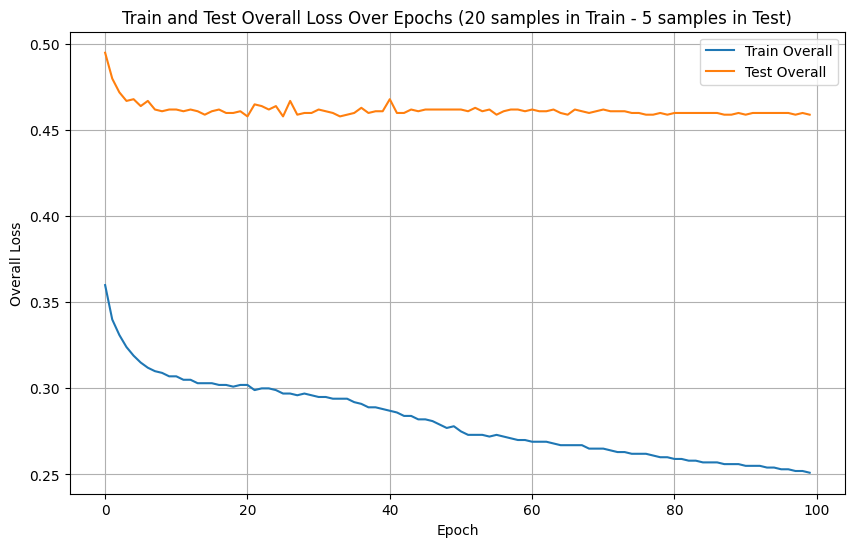

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the training and testing process
epochs = np.arange(100)
train_overall = [
    0.36, 0.34, 0.331, 0.324, 0.319, 0.315, 0.312, 0.31, 0.309, 0.307,
    0.307, 0.305, 0.305, 0.303, 0.303, 0.303, 0.302, 0.302, 0.301, 0.302,
    0.302, 0.299, 0.3, 0.3, 0.299, 0.297, 0.297, 0.296, 0.297, 0.296,
    0.295, 0.295, 0.294, 0.294, 0.294, 0.292, 0.291, 0.289, 0.289, 0.288,
    0.287, 0.286, 0.284, 0.284, 0.282, 0.282, 0.281, 0.279, 0.277, 0.278,
    0.275, 0.273, 0.273, 0.273, 0.272, 0.273, 0.272, 0.271, 0.27, 0.27,
    0.269, 0.269, 0.269, 0.268, 0.267, 0.267, 0.267, 0.267, 0.265, 0.265,
    0.265, 0.264, 0.263, 0.263, 0.262, 0.262, 0.262, 0.261, 0.26, 0.26,
    0.259, 0.259, 0.258, 0.258, 0.257, 0.257, 0.257, 0.256, 0.256, 0.256,
    0.255, 0.255, 0.255, 0.254, 0.254, 0.253, 0.253, 0.252, 0.252, 0.251
]

test_overall = [
    0.495, 0.48, 0.472, 0.467, 0.468, 0.464, 0.467, 0.462, 0.461, 0.462,
    0.462, 0.461, 0.462, 0.461, 0.459, 0.461, 0.462, 0.46, 0.46, 0.461,
    0.458, 0.465, 0.464, 0.462, 0.464, 0.458, 0.467, 0.459, 0.46, 0.46,
    0.462, 0.461, 0.46, 0.458, 0.459, 0.46, 0.463, 0.46, 0.461, 0.461,
    0.468, 0.46, 0.46, 0.462, 0.461, 0.462, 0.462, 0.462, 0.462, 0.462,
    0.462, 0.461, 0.463, 0.461, 0.462, 0.459, 0.461, 0.462, 0.462, 0.461,
    0.462, 0.461, 0.461, 0.462, 0.46, 0.459, 0.462, 0.461, 0.46, 0.461,
    0.462, 0.461, 0.461, 0.461, 0.46, 0.46, 0.459, 0.459, 0.46, 0.459,
    0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.459, 0.459, 0.46,
    0.459, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.459, 0.46, 0.459
]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_overall, label='Train Overall')
plt.plot(epochs, test_overall, label='Test Overall')
plt.xlabel('Epoch')
plt.ylabel('Overall Loss')
plt.title('Train and Test Overall Loss Over Epochs (20 samples in Train - 5 samples in Test)')
plt.legend()
plt.grid(True)
plt.show()

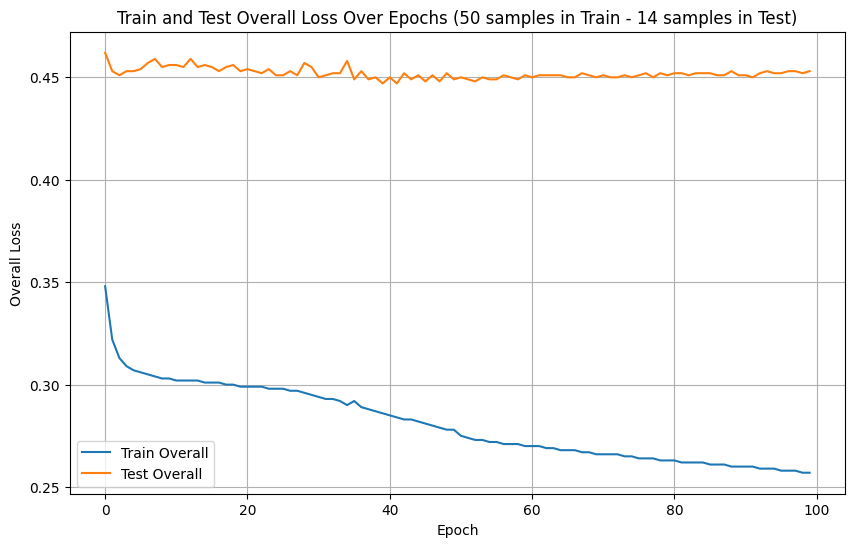

In [11]:
train_overall = [
    0.348, 0.322, 0.313, 0.309, 0.307, 0.306, 0.305, 0.304, 0.303, 0.303,
    0.302, 0.302, 0.302, 0.302, 0.301, 0.301, 0.301, 0.3, 0.3, 0.299,
    0.299, 0.299, 0.299, 0.298, 0.298, 0.298, 0.297, 0.297, 0.296, 0.295,
    0.294, 0.293, 0.293, 0.292, 0.29, 0.292, 0.289, 0.288, 0.287, 0.286,
    0.285, 0.284, 0.283, 0.283, 0.282, 0.281, 0.28, 0.279, 0.278, 0.278,
    0.275, 0.274, 0.273, 0.273, 0.272, 0.272, 0.271, 0.271, 0.271, 0.27,
    0.27, 0.27, 0.269, 0.269, 0.268, 0.268, 0.268, 0.267, 0.267, 0.266,
    0.266, 0.266, 0.266, 0.265, 0.265, 0.264, 0.264, 0.264, 0.263, 0.263,
    0.263, 0.262, 0.262, 0.262, 0.262, 0.261, 0.261, 0.261, 0.26, 0.26,
    0.26, 0.26, 0.259, 0.259, 0.259, 0.258, 0.258, 0.258, 0.257, 0.257
]

test_overall = [
    0.462, 0.453, 0.451, 0.453, 0.453, 0.454, 0.457, 0.459, 0.455, 0.456,
    0.456, 0.455, 0.459, 0.455, 0.456, 0.455, 0.453, 0.455, 0.456, 0.453,
    0.454, 0.453, 0.452, 0.454, 0.451, 0.451, 0.453, 0.451, 0.457, 0.455,
    0.45, 0.451, 0.452, 0.452, 0.458, 0.449, 0.453, 0.449, 0.45, 0.447,
    0.45, 0.447, 0.452, 0.449, 0.451, 0.448, 0.451, 0.448, 0.452, 0.449,
    0.45, 0.449, 0.448, 0.45, 0.449, 0.449, 0.451, 0.45, 0.449, 0.451,
    0.45, 0.451, 0.451, 0.451, 0.451, 0.45, 0.45, 0.452, 0.451, 0.45,
    0.451, 0.45, 0.45, 0.451, 0.45, 0.451, 0.452, 0.45, 0.452, 0.451,
    0.452, 0.452, 0.451, 0.452, 0.452, 0.452, 0.451, 0.451, 0.453, 0.451,
    0.451, 0.45, 0.452, 0.453, 0.452, 0.452, 0.453, 0.453, 0.452, 0.453
]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_overall, label='Train Overall')
plt.plot(epochs, test_overall, label='Test Overall')
plt.xlabel('Epoch')
plt.ylabel('Overall Loss')
plt.title('Train and Test Overall Loss Over Epochs (50 samples in Train - 14 samples in Test)')
plt.legend()
plt.grid(True)
plt.show()

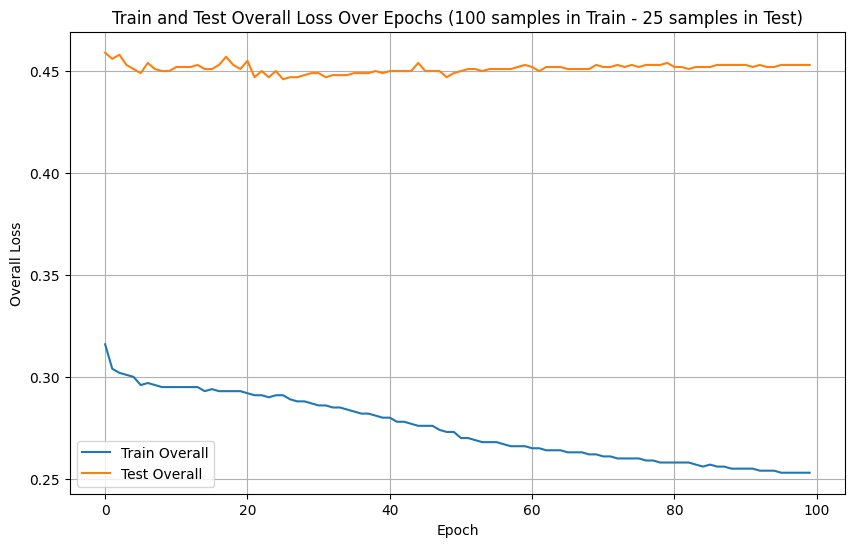

In [13]:
train_overall = [
    0.316, 0.304, 0.302, 0.301, 0.3, 0.296, 0.297, 0.296, 0.295, 0.295,
    0.295, 0.295, 0.295, 0.295, 0.293, 0.294, 0.293, 0.293, 0.293, 0.293,
    0.292, 0.291, 0.291, 0.29, 0.291, 0.291, 0.289, 0.288, 0.288, 0.287,
    0.286, 0.286, 0.285, 0.285, 0.284, 0.283, 0.282, 0.282, 0.281, 0.28,
    0.28, 0.278, 0.278, 0.277, 0.276, 0.276, 0.276, 0.274, 0.273, 0.273,
    0.27, 0.27, 0.269, 0.268, 0.268, 0.268, 0.267, 0.266, 0.266, 0.266,
    0.265, 0.265, 0.264, 0.264, 0.264, 0.263, 0.263, 0.263, 0.262, 0.262,
    0.261, 0.261, 0.26, 0.26, 0.26, 0.26, 0.259, 0.259, 0.258, 0.258,
    0.258, 0.258, 0.258, 0.257, 0.256, 0.257, 0.256, 0.256, 0.255, 0.255,
    0.255, 0.255, 0.254, 0.254, 0.254, 0.253, 0.253, 0.253, 0.253, 0.253
]

test_overall = [
    0.459, 0.456, 0.458, 0.453, 0.451, 0.449, 0.454, 0.451, 0.45, 0.45,
    0.452, 0.452, 0.452, 0.453, 0.451, 0.451, 0.453, 0.457, 0.453, 0.451,
    0.455, 0.447, 0.45, 0.447, 0.45, 0.446, 0.447, 0.447, 0.448, 0.449,
    0.449, 0.447, 0.448, 0.448, 0.448, 0.449, 0.449, 0.449, 0.45, 0.449,
    0.45, 0.45, 0.45, 0.45, 0.454, 0.45, 0.45, 0.45, 0.447, 0.449,
    0.45, 0.451, 0.451, 0.45, 0.451, 0.451, 0.451, 0.451, 0.452, 0.453,
    0.452, 0.45, 0.452, 0.452, 0.452, 0.451, 0.451, 0.451, 0.451, 0.453,
    0.452, 0.452, 0.453, 0.452, 0.453, 0.452, 0.453, 0.453, 0.453, 0.454,
    0.452, 0.452, 0.451, 0.452, 0.452, 0.452, 0.453, 0.453, 0.453, 0.453,
    0.453, 0.452, 0.453, 0.452, 0.452, 0.453, 0.453, 0.453, 0.453, 0.453
]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_overall, label='Train Overall')
plt.plot(epochs, test_overall, label='Test Overall')
plt.xlabel('Epoch')
plt.ylabel('Overall Loss')
plt.title('Train and Test Overall Loss Over Epochs (100 samples in Train - 25 samples in Test)')
plt.legend()
plt.grid(True)
plt.show()

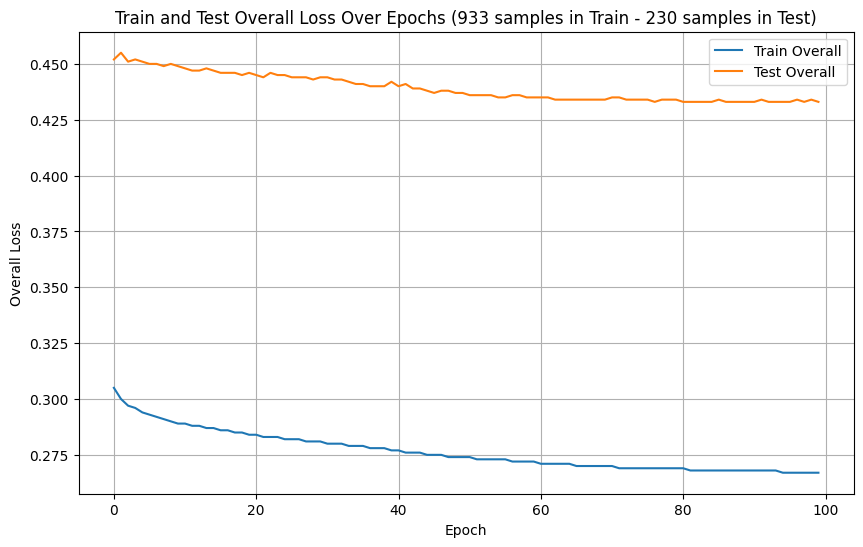

In [14]:
train_overall = [
    0.305, 0.300, 0.297, 0.296, 0.294, 0.293, 0.292, 0.291, 0.290, 0.289,
    0.289, 0.288, 0.288, 0.287, 0.287, 0.286, 0.286, 0.285, 0.285, 0.284, 
    0.284, 0.283, 0.283, 0.283, 0.282, 0.282, 0.282, 0.281, 0.281, 0.281, 
    0.280, 0.280, 0.280, 0.279, 0.279, 0.279, 0.278, 0.278, 0.278, 0.277, 
    0.277, 0.276, 0.276, 0.276, 0.275, 0.275, 0.275, 0.274, 0.274, 0.274, 
    0.274, 0.273, 0.273, 0.273, 0.273, 0.273, 0.272, 0.272, 0.272, 0.272, 
    0.271, 0.271, 0.271, 0.271, 0.271, 0.270, 0.270, 0.270, 0.270, 0.270, 
    0.270, 0.269, 0.269, 0.269, 0.269, 0.269, 0.269, 0.269, 0.269, 0.269, 
    0.269, 0.268, 0.268, 0.268, 0.268, 0.268, 0.268, 0.268, 0.268, 0.268, 
    0.268, 0.268, 0.268, 0.268, 0.267, 0.267, 0.267, 0.267, 0.267, 0.267,
]

test_overall = [
    0.452, 0.455, 0.451, 0.452, 0.451, 0.450, 0.450, 0.449, 0.450, 0.449,
    0.448, 0.447, 0.447, 0.448, 0.447, 0.446, 0.446, 0.446, 0.445, 0.446,
    0.445, 0.444, 0.446, 0.445, 0.445, 0.444, 0.444, 0.444, 0.443, 0.444,
    0.444, 0.443, 0.443, 0.442, 0.441, 0.441, 0.440, 0.440, 0.440, 0.442,
    0.440, 0.441, 0.439, 0.439, 0.438, 0.437, 0.438, 0.438, 0.437, 0.437,
    0.436, 0.436, 0.436, 0.436, 0.435, 0.435, 0.436, 0.436, 0.435, 0.435,
    0.435, 0.435, 0.434, 0.434, 0.434, 0.434, 0.434, 0.434, 0.434, 0.434,
    0.435, 0.435, 0.434, 0.434, 0.434, 0.434, 0.433, 0.434, 0.434, 0.434,
    0.433, 0.433, 0.433, 0.433, 0.433, 0.434, 0.433, 0.433, 0.433, 0.433,
    0.433, 0.434, 0.433, 0.433, 0.433, 0.433, 0.434, 0.433, 0.434, 0.433
]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_overall, label='Train Overall')
plt.plot(epochs, test_overall, label='Test Overall')
plt.xlabel('Epoch')
plt.ylabel('Overall Loss')
plt.title('Train and Test Overall Loss Over Epochs (933 samples in Train - 230 samples in Test)')
plt.legend()
plt.grid(True)
plt.show()

Overall, the loss function 1 have an angular error between the real and predicted direction fields more than 50°. This is not acceptable for retopology.

### Evalution of Loss Function 2

Here we plot one example of the ground truth direction field and the predicted direction field using the second loss function.

In [16]:
import plotly.express as px
import pandas as pd
from math import sin, cos


def convert_spherical_to_cartesian(r, theta, phi):
    x = r * sin(theta) * cos(phi)
    y = r * sin(theta) * sin(phi)
    z = r * cos(theta)
    return x,y,z
 
x1,y1,z1 = convert_spherical_to_cartesian(1, 6.947085261997695271e-01, 2.261645934151683690e-01)
x2,y2,z2 = convert_spherical_to_cartesian(1, 2.342013730646936853e+00, -4.335735359697641678e-01)

x3,y3,z3 = convert_spherical_to_cartesian(1, -2.5404, -0.3407)
x4,y4,z4 = convert_spherical_to_cartesian(1, -1.8457, -3.0484)

data = {
    'x': [0, x1, 0, x2, 0, x3, 0, x4],
    'y': [0, y1, 0, y2, 0, y3, 0, y4],
    'z': [0, z1, 0, z2, 0, z3, 0, z4]
}

df = pd.DataFrame(data)

fig = px.scatter_3d(df, x='x', y='y', z='z')

fig.add_scatter3d(x=[0, x1], y=[0, y1], z=[0, z1], mode='lines', line=dict(color='red', width=5), name='vector1 real')
fig.add_scatter3d(x=[0, x2], y=[0, y2], z=[0, z2], mode='lines', line=dict(color='lightgreen', width=5), name='vector2 real')
fig.add_scatter3d(x=[0, x3], y=[0, y3], z=[0, z3], mode='lines', line=dict(color='darkred', width=5), name='vector1 predicted')
fig.add_scatter3d(x=[0, x4], y=[0, y4], z=[0, z4], mode='lines', line=dict(color='darkgreen', width=5), name='vector2 predicted')


fig.show()

In this case, we can notice that the predicted direction field is quite similar to the real one. This shows that the cosine similarity loss function is more suitable for our task.

103


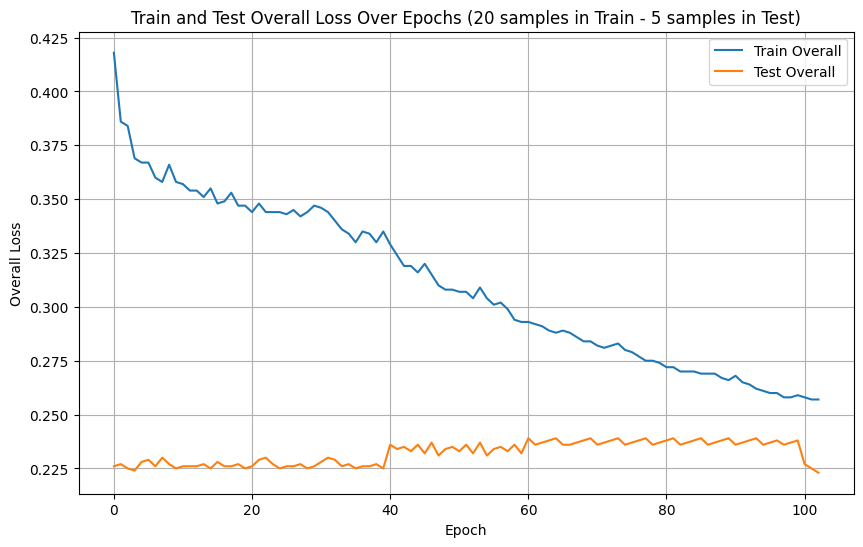

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the training and testing process
train_overall = [0.418, 0.386, 0.384, 0.369, 0.367, 0.367, 0.36, 0.358, 0.366, 0.358, 0.357, 0.354, 0.354, 0.351, 0.355, 0.348, 0.349, 0.353, 0.347, 0.347, 0.344, 0.348, 0.344, 0.344, 0.344, 0.343, 0.345, 0.342, 0.344, 0.347, 0.346, 0.344, 0.34, 0.336, 0.334, 0.33, 0.335, 0.334, 0.33, 0.335, 0.329, 0.324, 0.319, 0.319, 0.316, 0.32, 0.315, 0.31, 0.308, 0.308, 0.307, 0.307, 0.304, 0.309, 0.304, 0.301, 0.302, 0.299, 0.294, 0.293, 0.293, 0.292, 0.291, 0.289, 0.288, 0.289, 0.288, 0.286, 0.284, 0.284, 0.282, 0.281, 0.282, 0.283, 0.28, 0.279, 0.277, 0.275, 0.275, 0.274, 0.272, 0.272, 0.27, 0.27, 0.27, 0.269, 0.269, 0.269, 0.267, 0.266, 0.268, 0.265, 0.264, 0.262, 0.261, 0.26, 0.26, 0.258, 0.258, 0.259, 0.258, 0.257, 0.257]

print(len(train_overall))
test_overall = [0.226, 0.227, 0.225, 0.224, 0.228, 0.229, 0.226, 0.230, 0.227, 0.225, 
    0.226, 0.226, 0.226, 0.227, 0.225, 0.228, 0.226, 0.226, 0.227, 0.225, 
    0.226, 0.229, 0.230, 0.227, 0.225, 0.226, 0.226, 0.227, 0.225, 0.226, 
    0.228, 0.230, 0.229, 0.226, 0.227, 0.225, 0.226, 0.226, 0.227, 0.225, 
    0.236, 0.234, 0.235, 0.233, 0.236, 0.232, 0.237, 0.231, 0.234, 0.235, 
    0.233, 0.236, 0.232, 0.237, 0.231, 0.234, 0.235, 0.233, 0.236, 0.232, 0.239, 0.236, 0.237, 0.238, 0.239, 0.236, 0.236,
    0.237, 0.238, 0.239, 0.236, 0.237, 0.238, 0.239, 0.236, 0.237, 0.238, 
    0.239, 0.236, 0.237, 0.238, 0.239, 0.236, 0.237, 0.238, 0.239, 0.236, 
    0.237, 0.238, 0.239, 0.236, 0.237, 0.238, 0.239, 0.236, 0.237, 0.238, 
    0.236, 0.237, 0.238, 0.227, 0.225, 0.223
]
epochs = np.arange(len(train_overall))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_overall, label='Train Overall')
plt.plot(epochs, test_overall, label='Test Overall')
plt.xlabel('Epoch')
plt.ylabel('Overall Loss')
plt.title('Train and Test Overall Loss Over Epochs (20 samples in Train - 5 samples in Test)')
plt.legend()
plt.grid(True)
plt.show()

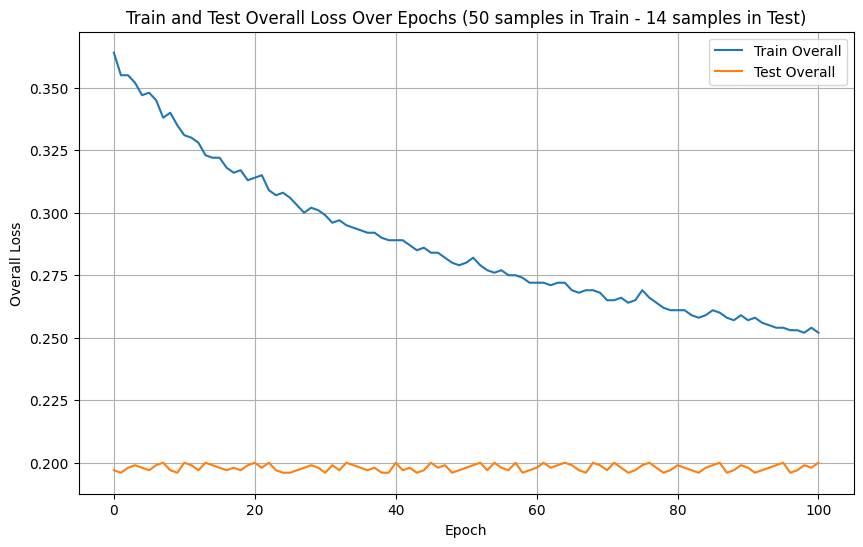

In [48]:
train_overall = [0.364, 0.355, 0.355, 0.352, 0.347, 0.348, 0.345, 0.338, 0.34, 0.335, 0.331, 0.33, 0.328, 0.323, 0.322, 0.322, 0.318, 0.316, 0.317, 0.313, 0.314, 0.315, 0.309, 0.307, 0.308, 0.306, 0.303, 0.3, 0.302, 0.301, 0.299, 0.296, 0.297, 0.295, 0.294, 0.293, 0.292, 0.292, 0.29, 0.289, 0.289, 0.289, 0.287, 0.285, 0.286, 0.284, 0.284, 0.282, 0.28, 0.279, 0.28, 0.282, 0.279, 0.277, 0.276, 0.277, 0.275, 0.275, 0.274, 0.272, 0.272, 0.272, 0.271, 0.272, 0.272, 0.269, 0.268, 0.269, 0.269, 0.268, 0.265, 0.265, 0.266, 0.264, 0.265, 0.269, 0.266, 0.264, 0.262, 0.261, 0.261, 0.261, 0.259, 0.258, 0.259, 0.261, 0.26, 0.258, 0.257, 0.259, 0.257, 0.258, 0.256, 0.255, 0.254, 0.254, 0.253, 0.253, 0.252, 0.254, 0.252]

test_overall = [0.197, 0.196, 0.198, 0.199, 0.198, 0.197, 0.199, 0.200, 0.197, 0.196, 0.200, 0.199, 0.197, 0.200, 0.199, 0.198, 0.197, 0.198, 0.197, 0.199, 0.200, 0.198, 0.200, 0.197, 0.196, 0.196, 0.197, 0.198, 0.199, 0.198, 0.196, 0.199, 0.197, 0.200, 0.199, 0.198, 0.197, 0.198, 0.196, 0.196, 0.200, 0.197, 0.198, 0.196, 0.197, 0.200, 0.198, 0.199, 0.196, 0.197, 0.198, 0.199, 0.200, 0.197, 0.200, 0.198, 0.197, 0.200, 0.196, 0.197, 0.198, 0.200, 0.198, 0.199, 0.200, 0.199, 0.197, 0.196, 0.200, 0.199, 0.197, 0.200, 0.198, 0.196, 0.197, 0.199, 0.200, 0.198, 0.196, 0.197, 0.199, 0.198, 0.197, 0.196, 0.198, 0.199, 0.200, 0.196, 0.197, 0.199, 0.198, 0.196, 0.197, 0.198, 0.199, 0.200, 0.196, 0.197, 0.199, 0.198, 0.200]

epochs = np.arange(len(train_overall))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_overall, label='Train Overall')
plt.plot(epochs, test_overall, label='Test Overall')
plt.xlabel('Epoch')
plt.ylabel('Overall Loss')
plt.title('Train and Test Overall Loss Over Epochs (50 samples in Train - 14 samples in Test)')
plt.legend()
plt.grid(True)
plt.show()

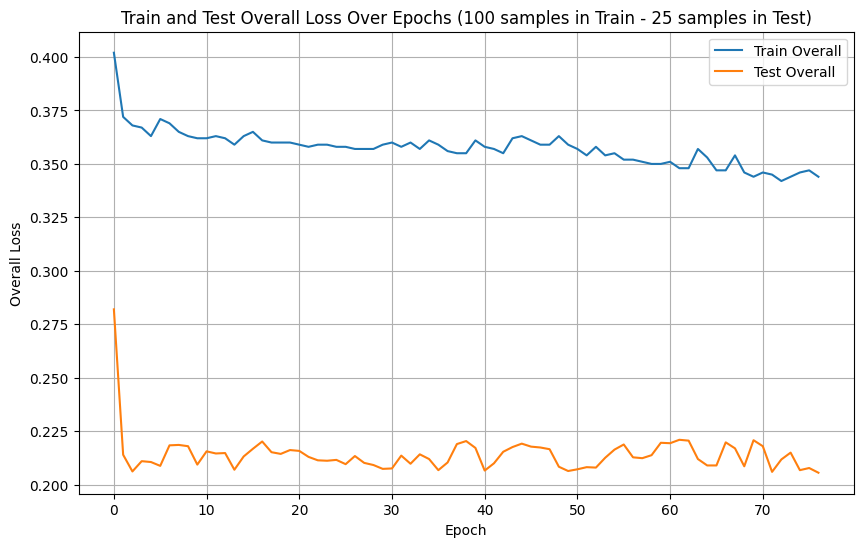

In [70]:
train_overall = [0.402, 0.372, 0.368, 0.367, 0.363, 0.371, 0.369, 0.365, 0.363, 0.362, 0.362, 0.363, 0.362, 0.359, 0.363, 0.365, 0.361, 0.36, 0.36, 0.36, 0.359, 0.358, 0.359, 0.359, 0.358, 0.358, 0.357, 0.357, 0.357, 0.359, 0.36, 0.358, 0.36, 0.357, 0.361, 0.359, 0.356, 0.355, 0.355, 0.361, 0.358, 0.357, 0.355, 0.362, 0.363, 0.361, 0.359, 0.359, 0.363, 0.359, 0.357, 0.354, 0.358, 0.354, 0.355, 0.352, 0.352, 0.351, 0.35, 0.35, 0.351, 0.348, 0.348, 0.357, 0.353, 0.347, 0.347, 0.354, 0.346, 0.344, 0.346, 0.345, 0.342, 0.344, 0.346, 0.347, 0.344]

test_overall = [0.282, 0.214, 0.2062, 0.211, 0.2106, 0.2088, 0.2184, 0.2186, 0.218, 0.2094,
0.2156, 0.2146, 0.2148, 0.207, 0.2132, 0.2168, 0.2202, 0.2152, 0.2144, 0.2162,
0.2158, 0.213, 0.2114, 0.2112, 0.2116, 0.2096, 0.2134, 0.2102, 0.2092, 0.2074,
0.2076, 0.2136, 0.2098, 0.2142, 0.212, 0.2068, 0.2104, 0.219, 0.2204, 0.2172,
0.2066, 0.210, 0.2154, 0.2176, 0.2192, 0.2178, 0.2174, 0.2166, 0.2084,
0.2064, 0.2072, 0.2082, 0.208, 0.2126, 0.2164, 0.2188, 0.2128, 0.2124, 0.2138,
0.2196, 0.2194, 0.221, 0.2206, 0.212, 0.209, 0.209,0.2198, 0.217, 0.2086, 0.2208,
0.218, 0.206, 0.2118, 0.215, 0.2068, 0.2078, 0.2056]

epochs = np.arange(len(train_overall))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_overall, label='Train Overall')
plt.plot(epochs, test_overall, label='Test Overall')
plt.xlabel('Epoch')
plt.ylabel('Overall Loss')
plt.title('Train and Test Overall Loss Over Epochs (100 samples in Train - 25 samples in Test)')
plt.legend()
plt.grid(True)
plt.show()

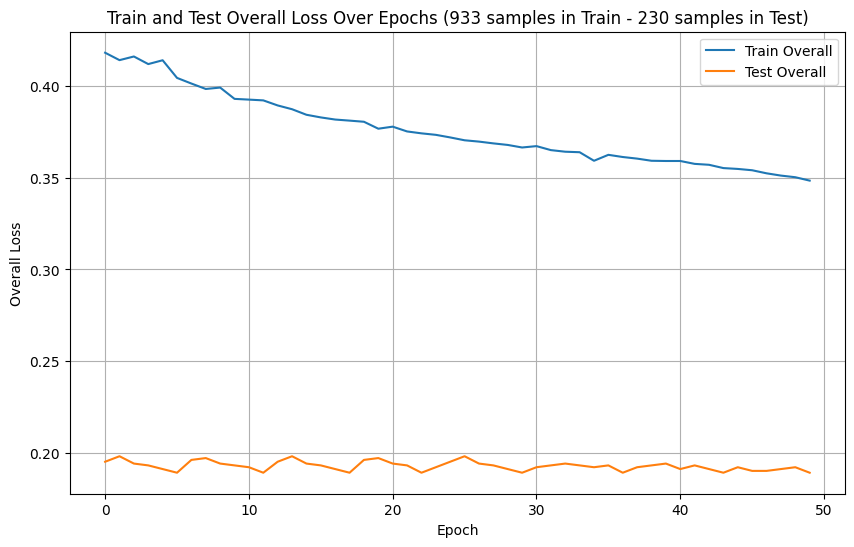

In [69]:
train_overall = [0.4183685208612257, 0.41431832114893917, 0.41631013031533596, 0.4121641746987414, 
0.4142565371330702, 0.404617770593047, 0.4015341883406127, 0.398571736538173, 
0.39934249505409135, 0.3931646354222788, 0.39276198063416135, 0.3923425206686051, 
0.3895780302948484, 0.3875124922539364, 0.3844852241771012, 0.3830362174495627, 
0.38187492918457966, 0.38128656895346626, 0.3806637416768972, 0.3768736785864771, 
0.37799135936696244, 0.3753767857732162, 0.3743386419773877, 0.3735252182194677, 
0.37210786336697204, 0.37054922625674946, 0.3698292440207234, 0.3688561551000537, 
0.3680081160171007, 0.36661562394691204, 0.36736122942081545, 0.36518139036595746, 
0.3643068038910671, 0.364033016677294, 0.3593613040131987, 0.3626065371621469, 0.36141539370757634, 
0.3605390513386729, 0.3593613040131987, 0.3592402111082788, 0.3592402111082788, 0.3576686495878311, 
0.3571666200492226, 0.35536732422578334, 0.3549030247756122, 0.3541830067438291, 
0.35251384702780494, 0.3512702347786182, 0.350375855086267, 0.3485207838841649]


test_overall = [0.195, 0.198, 0.194, 0.193, 0.191, 0.189, 0.196, 0.197, 0.194, 0.193, 
0.192, 0.189, 0.195, 0.198, 0.194, 0.193, 0.191, 0.189, 0.196, 0.197, 
0.194, 0.193, 0.189, 0.192, 0.195, 0.198, 0.194, 0.193, 0.191, 0.189, 
0.192, 0.193, 0.194, 0.193, 0.192,0.193, 0.189,0.192, 0.193, 0.194, 0.191, 0.193, 
0.191, 0.189, 0.192, 0.190, 0.190, 0.191, 0.192, 0.189]

epochs = np.arange(len(train_overall))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_overall, label='Train Overall')
plt.plot(epochs, test_overall, label='Test Overall')
plt.xlabel('Epoch')
plt.ylabel('Overall Loss')
plt.title('Train and Test Overall Loss Over Epochs (933 samples in Train - 230 samples in Test)')
plt.legend()
plt.grid(True)
plt.show()

# Conclusion

In this project, we explored the use of diffusion networks to compute direction fields for quad mesh retopology. Our aim was to develop a method capable of capturing the intricate structures found in meshes crafted by experienced designers. This approach harnesses domain knowledge encoded in existing meshes, enabling the network to generate direction fields that better mimic expert designs.

We achieved a test error (angular error) of approximately 35° in predicting the angular variables for the direction field with the cosine loss. While this suggests moderate accuracy, there's room for improvement. The main challenge we encountered was the limited dataset available.

In the realm of quad mesh generation, the desired mesh topology often varies depending on the specific application. While our diffusion network approach effectively captures the intricate structures found in expert-designed meshes, it may not fully address the need for user-controlled topology adjustments (for instance the same mesh could have a different topology if we are in the context of character animation or in physics simulation).

To address this limitation, we suggest integrating a transformer-based architecture into our method. Transformers have demonstrated remarkable capabilities in natural language processing tasks, particularly in capturing long-range dependencies within text sequences. This ability aligns well with the task of incorporating user-provided topology information, as it often involves understanding relationships between mesh elements across the entire structure.
One of the reasons for using a diffusion network architecture is its compatibility with transformer-based models.
By incorporating a transformer-based module, we can provide a mechanism for users to specify their desired mesh topology. The user could input a text description or a high-level sketch of the desired topology, and the transformer would then extract and translate this information into a form compatible with our diffusion network. 

